# Momentum resolution

In the following, all measurements are in metres, resp. radians.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## Tracking resolution

### Single trajectory

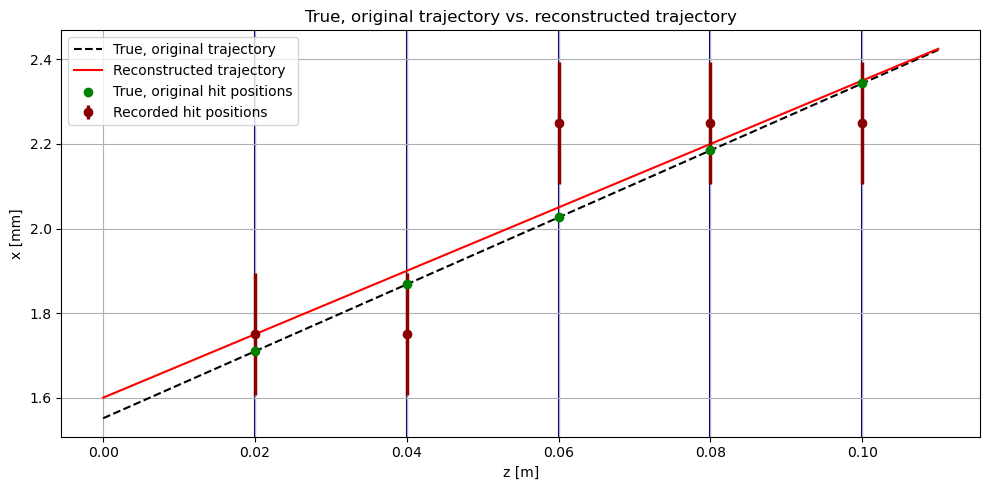

x0_true = 1.551 mm, s0_true = 0.008 rad
x0_reco = 1.600 mm ± 0.151 mm
s0_reco = 0.007 ± 0.002 rad


In [15]:
n_planes = 5
delta_z = 0.02  # 2 cm in metres
cell_width = 0.0005  # 500 micrometers in metres

np.random.seed(14)

x0_true = np.random.normal(0, 0.001)
s0_true = np.random.normal(0, 0.1)

z0 = 0

# Calculate the z and x positions of the planes 
# To use curve_fit, we need to have a function defined, so we use a function to calculate the x_positions
def trajectory_fun(z_position, x0, angle): 
    return x0 + z_position * np.tan(angle) # Calculating the vertical position using trigonometry

z_positions = np.arange(1, n_planes + 1) * delta_z
x_positions = trajectory_fun(z_positions, x0_true, s0_true)

# Calculate which cell was hit
cells_hit = np.floor(x_positions / cell_width) #.astype(int) # Also works if the x_position is negative -> e.g. cell "-1"
cells_hit_middle = cells_hit * cell_width + cell_width / 2

# Calculate the uncertainty
std_hit = cell_width / np.sqrt(12) # Modelled as explained by Valeriia
# Missing influence of the uncertainty of the spread of the slope/angle ???



# Use curve_fit, popt = optimal values for the parameters s.t. rss is minimised, pcov = estimated approximate covariance of popt
popt, pcov = curve_fit(trajectory_fun, z_positions, cells_hit_middle, p0 = None, sigma = std_hit, absolute_sigma = True)

x0_reco, s0_reco = popt
std_x0_reco, std_s0_reco = np.sqrt(np.diag(pcov)) # Uncertainties on the fitted parameters, see documentation (used later for pull distributions)


# Plotting
grid = np.linspace(0, z_positions[-1] + delta_z/2, num = 1001)
true_traj_z = trajectory_fun(grid, x0_true, s0_true)
reco_traj_z = trajectory_fun(grid, x0_reco, s0_reco)

plt.figure(figsize=(10,5))
for z in z_positions:
    plt.axvline(x=z, color="darkblue", linestyle='-', linewidth=1.5, zorder=0) # Detector planes
# I multiplied everything by thousand such that the y-axis has millimetre values
plt.plot(grid, 1000*true_traj_z, "k--", label = "True, original trajectory") 
plt.plot(grid, 1000*reco_traj_z, "r-", label = "Reconstructed trajectory")
plt.scatter(z_positions, 1000*x_positions, color = "g", label = "True, original hit positions", zorder = 3)
plt.errorbar(z_positions, 1000*cells_hit_middle, yerr = 1000*std_hit, fmt = "o", color = "darkred", linewidth = 2.5, label = "Recorded hit positions")

plt.xlabel("z [m]")
plt.ylabel("x [mm]")
plt.grid()
plt.legend()
plt.title("True, original trajectory vs. reconstructed trajectory")
plt.tight_layout()
plt.show()


print(f"x0_true = {x0_true*1000:.3f} mm, s0_true = {s0_true:.3f} rad")
print(f"x0_reco = {x0_reco*1000:.3f} mm ± {std_x0_reco*1000:.3f} mm")
print(f"s0_reco = {s0_reco:.3f} ± {std_s0_reco:.3f} rad")



We modeled it with /sqrt(12) - but we neglected the multiple scattering part. Important to mention this!

### Multiple trajectories

We see that we account for too little uncertainty when looking at the pulls.

Reasons (if it was a real detector):
- No electronics noise simulated
- Detector misalignments (z positions cannot be exact)

We see that especially the uncertainty of s0 is underestimated. This is because we're fitting s0 directly, but because tan(s0) is nonlinear, the impact of errors in s0 grows with s0, and your uncertainty model doesn’t fully capture that.

C:\Users\flori\AppData\Local\Temp\ipykernel_17628\1425260623.py:32: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(trajectory_fun, z_positions, cells_hit_middle, p0 = None, sigma = std_hit, absolute_sigma = True)


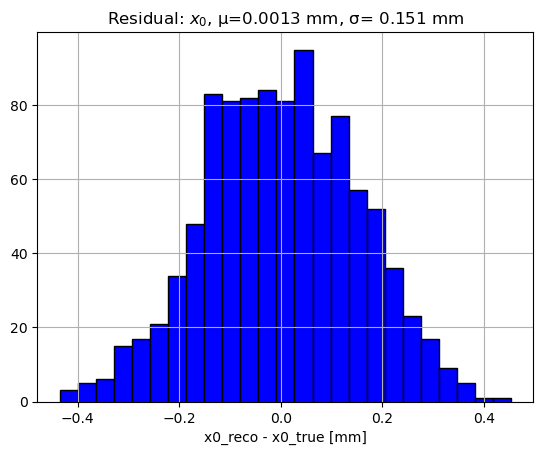

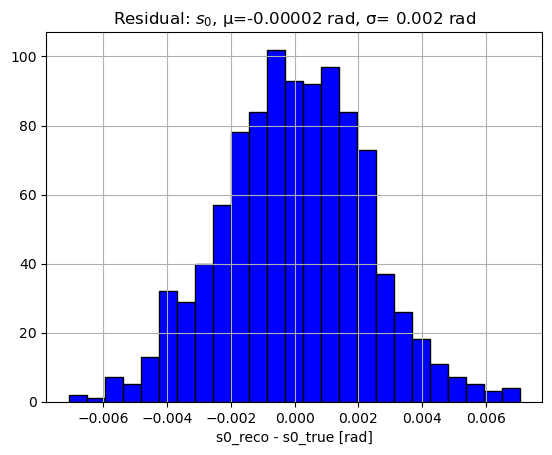

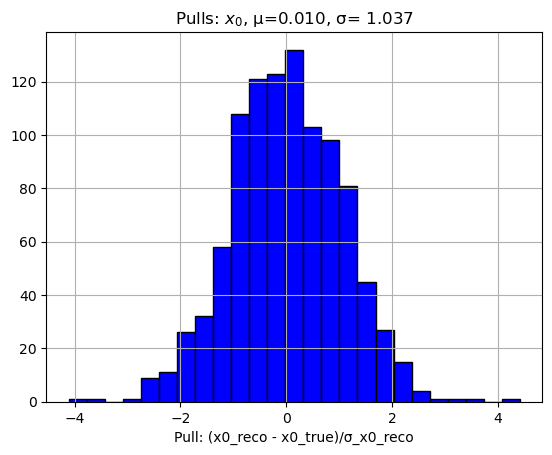

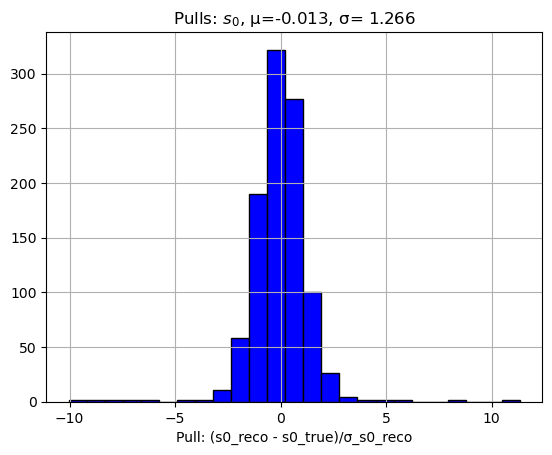

In [23]:
n_trajectories = 1000
z0 = 0
delta_z = 0.02  # 2 cm in metres
n_planes = 5
cell_width = 0.0005  # 500 micrometers in metres

# Calculate the uncertainty
std_hit = cell_width / np.sqrt(12) # Modelled as explained by Valeriia

z_positions = np.arange(1, n_planes + 1) * delta_z

np.random.seed(14)

# Arrays for the residuals and for the pulls
resi_s0 = np.full(n_trajectories, np.nan)
resi_x0 = np.full(n_trajectories, np.nan)

pulls_s0 = np.full(n_trajectories, np.nan)
pulls_x0 = np.full(n_trajectories, np.nan)

for i in range(n_trajectories):
    x0_true = np.random.normal(0, 0.001)
    s0_true = np.random.normal(0, 0.1)

    x_positions = trajectory_fun(z_positions, x0_true, s0_true) 

    # Calculate which cell was hit
    cells_hit = np.floor(x_positions / cell_width) #.astype(int) # Also works if the x_position is negative -> e.g. cell "-1"
    cells_hit_middle = cells_hit * cell_width + cell_width / 2

    # Use curve_fit, popt = optimal values for the parameters s.t. rss is minimised, pcov = estimated approximate covariance of popt
    popt, pcov = curve_fit(trajectory_fun, z_positions, cells_hit_middle, p0 = None, sigma = std_hit, absolute_sigma = True)

    x0_reco, s0_reco = popt
    std_x0_reco, std_s0_reco = np.sqrt(np.diag(pcov)) # Uncertainties on the fitted parameters, see documentation (used later for pull distributions)

    resi_s0[i] = s0_reco - s0_true
    resi_x0[i] = x0_reco - x0_true

    # pull = (reconstructed_quantity - generated_quantity)/uncertainty_on_reconstructed_quantity
    pulls_s0[i] = (s0_reco - s0_true)/std_s0_reco
    pulls_x0[i] = (x0_reco - x0_true)/std_x0_reco


# Taking the mean and standard deviation for the residuals
mean_resi_s0 = np.mean(resi_s0)
mean_resi_x0 = np.mean(resi_x0)

std_resi_s0 = np.std(resi_s0)
std_resi_x0 = np.std(resi_x0)


# Plot these distributions as histograms
plt.figure()
plt.hist(resi_x0 * 1000, bins = 25, color = "blue", edgecolor = "black")
plt.title(f"Residual: $x_0$, μ={mean_resi_x0 * 1000:.4f} mm, σ={std_resi_x0 * 1000: .3f} mm")
plt.xlabel("x0_reco - x0_true [mm]")
plt.grid()
plt.show()

plt.figure()
plt.hist(resi_s0, bins = 25, color = "blue", edgecolor = "black")
plt.title(f"Residual: $s_0$, μ={mean_resi_s0:.5f} rad, σ={std_resi_s0: .3f} rad")
plt.xlabel("s0_reco - s0_true [rad]")
plt.grid()
plt.show()


# Taking the mean and standard deviation for the pulls
mean_pulls_s0 = np.mean(pulls_s0)
mean_pulls_x0 = np.mean(pulls_x0)

std_pulls_s0 = np.std(pulls_s0)
std_pulls_x0 = np.std(pulls_x0)

# Plot these distributions as histograms
plt.figure()
plt.hist(pulls_x0, bins = 25, color = "blue", edgecolor = "black")
plt.title(f"Pulls: $x_0$, μ={mean_pulls_x0:.3f}, σ={std_pulls_x0: .3f}")
plt.xlabel("Pull: (x0_reco - x0_true)/σ_x0_reco")
plt.grid()
plt.show()

plt.figure()
plt.hist(pulls_s0, bins = 25, color = "blue", edgecolor = "black")
plt.title(f"Pulls: $s_0$, μ={mean_pulls_s0:.3f}, σ={std_pulls_s0: .3f}")
plt.xlabel("Pull: (s0_reco - s0_true)/σ_s0_reco")
plt.grid()
plt.show()


    

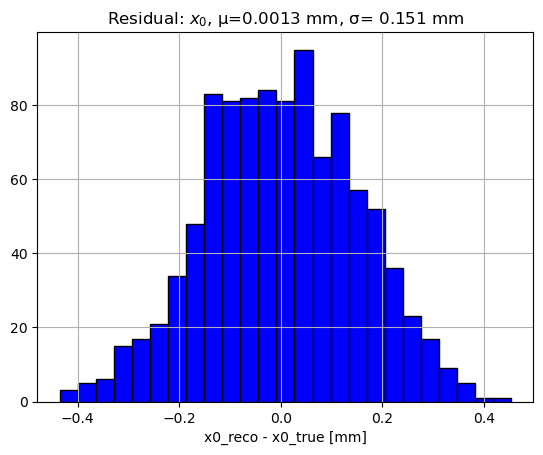

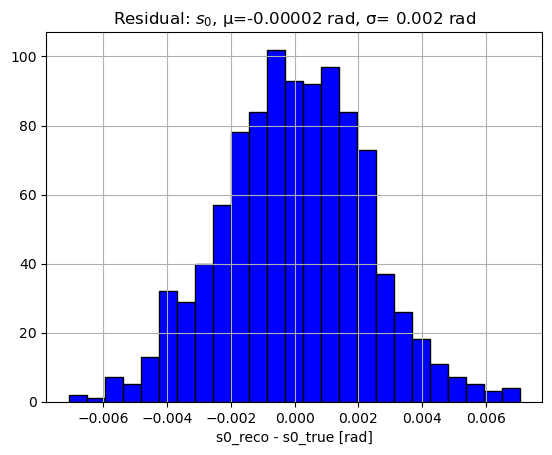

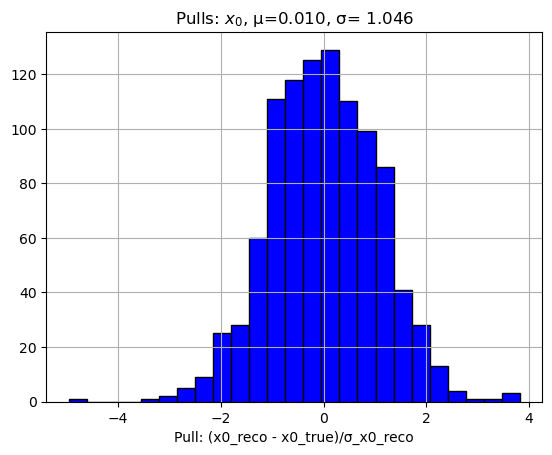

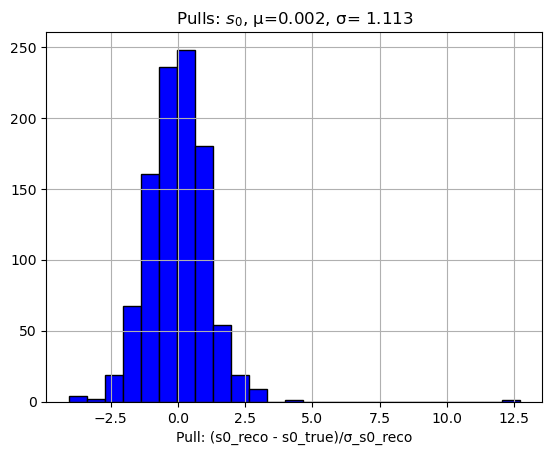

In [34]:
n_trajectories = 1000
z0 = 0
delta_z = 0.02  # 2 cm in metres
n_planes = 5
cell_width = 0.0005  # 500 micrometers in metres

# Calculate the uncertainty
std_hit = cell_width / np.sqrt(12) # Modelled as explained by Valeriia

z_positions = np.arange(1, n_planes + 1) * delta_z

def trajectory_fun_linear(z_position, x0, slope): 
    return x0 + z_position * slope # Calculating the vertical position using trigonometry

np.random.seed(14)

# Arrays for the residuals and for the pulls
resi_s0 = np.full(n_trajectories, np.nan)
resi_x0 = np.full(n_trajectories, np.nan)

pulls_s0 = np.full(n_trajectories, np.nan)
pulls_x0 = np.full(n_trajectories, np.nan)

for i in range(n_trajectories):
    x0_true = np.random.normal(0, 0.001)
    s0_true = np.random.normal(0, 0.1)

    slope_true = np.tan(s0_true)

    x_positions = trajectory_fun_linear(z_positions, x0_true, slope_true) 

    # Calculate which cell was hit
    cells_hit = np.floor(x_positions / cell_width) #.astype(int) # Also works if the x_position is negative -> e.g. cell "-1"
    cells_hit_middle = cells_hit * cell_width + cell_width / 2

    # Use curve_fit, popt = optimal values for the parameters s.t. rss is minimised, pcov = estimated approximate covariance of popt
    popt, pcov = curve_fit(trajectory_fun_linear, z_positions, cells_hit_middle, p0 = None, sigma = std_hit, absolute_sigma = True)

    x0_reco, slope_reco = popt
    std_x0_reco, std_slope_reco = np.sqrt(np.diag(pcov)) # Uncertainties on the fitted parameters, see documentation (used later for pull distributions)

    s0_reco = np.arctan(slope_reco)
    std_s0_reco = std_slope_reco / (1 + slope_reco**2)

    resi_s0[i] = s0_reco - s0_true
    resi_x0[i] = x0_reco - x0_true

    # pull = (reconstructed_quantity - generated_quantity)/uncertainty_on_reconstructed_quantity
    pulls_s0[i] = (s0_reco - s0_true)/(std_slope_reco / (1 + slope_reco**2))
    pulls_x0[i] = (x0_reco - x0_true)/std_x0_reco


# Taking the mean and standard deviation for the residuals
mean_resi_s0 = np.mean(resi_s0)
mean_resi_x0 = np.mean(resi_x0)

std_resi_s0 = np.std(resi_s0)
std_resi_x0 = np.std(resi_x0)


# Plot these distributions as histograms
plt.figure()
plt.hist(resi_x0 * 1000, bins = 25, color = "blue", edgecolor = "black")
plt.title(f"Residual: $x_0$, μ={mean_resi_x0 * 1000:.4f} mm, σ={std_resi_x0 * 1000: .3f} mm")
plt.xlabel("x0_reco - x0_true [mm]")
plt.grid()
plt.show()

plt.figure()
plt.hist(resi_s0, bins = 25, color = "blue", edgecolor = "black")
plt.title(f"Residual: $s_0$, μ={mean_resi_s0:.5f} rad, σ={std_resi_s0: .3f} rad")
plt.xlabel("s0_reco - s0_true [rad]")
plt.grid()
plt.show()


# Taking the mean and standard deviation for the pulls
mean_pulls_s0 = np.mean(pulls_s0)
mean_pulls_x0 = np.mean(pulls_x0)

std_pulls_s0 = np.std(pulls_s0)
std_pulls_x0 = np.std(pulls_x0)

# Plot these distributions as histograms
plt.figure()
plt.hist(pulls_x0, bins = 25, color = "blue", edgecolor = "black")
plt.title(f"Pulls: $x_0$, μ={mean_pulls_x0:.3f}, σ={std_pulls_x0: .3f}")
plt.xlabel("Pull: (x0_reco - x0_true)/σ_x0_reco")
plt.grid()
plt.show()

plt.figure()
plt.hist(pulls_s0, bins = 25, color = "blue", edgecolor = "black")
plt.title(f"Pulls: $s_0$, μ={mean_pulls_s0:.3f}, σ={std_pulls_s0: .3f}")
plt.xlabel("Pull: (s0_reco - s0_true)/σ_s0_reco")
plt.grid()
plt.show()


    